 **Topic and Sentiment Mining in The New York Times Articles and Comments**



**Imports**

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.23.5
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install bertopic
!pip install pyLDAvis
!pip install gensim
!pip install kneed
!pip install --upgrade gensim

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 req

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's depend

In [ ]:
import numpy as np
from gensim import corpora
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import spacy
import re
import nltk
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from kneed import KneeLocator
from wordcloud import WordCloud
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 **Data cleaning**
Cleaning the input to ensure articles is a string and not null, lowercase, no URL and no non-alphabetic characters, no stop words, lemmatizing the words, keeping only valid English words.

We are also filtering the articles which are short that may lack enough information and long ones may be harder to process efficiently.

In [ ]:
# lemmatizer
lemmatizer = WordNetLemmatizer()
english_words_set = set(words.words())

def clean_text(text):
    # Check for NaN and string
    if not isinstance(text, str) or pd.isnull(text):
        return None
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize and lemmatize
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word in english_words_set]

    # Remove stopwords
    cleaned_words = [
        word for word in lemmatized_tokens if word not in ENGLISH_STOP_WORDS
    ]
    cleaned_text = " ".join(cleaned_words)

    # keep sentences with more than 10 words or less than 50 words
    word_count = len(cleaned_words)
    if word_count < 7 or word_count > 50:
        return None
    return cleaned_text

# Load the data
data_url = '/content/nyt-articles-2020.csv'
articles_raw_df = pd.read_csv(data_url).iloc[:16787]
articles = articles_raw_df['abstract']
articles_cleaned = articles.apply(clean_text).dropna()

print(articles_cleaned.head())

2    year long earth cosmic debris list major meteo...
3    miss eclipse meteor shower rocket launch astro...
4                 year space just ended come new orbit
5    ability deploy attack embassy support clear power
6                  slip son just make sure right place
Name: abstract, dtype: object


In [ ]:
# count of total sentences in articles_cleaned
sentence_counts = articles_cleaned.str.split('.').str.len()
print(f"Total number of sentences: {sentence_counts.sum()}")

Total number of sentences: 10092


**Embedding**

 **Sentence-BERT**

BERT is great at understanding the context of words in a sentence but it does not directly give embeddings for complete sentences. Sentence-BERT generate sentence-level embeddings, making it suitable for tasks like text clustering and information retrieval.

all-MiniLM-L6-v2 is a pre-trained Sentence-BERT model. MiniLM models are smaller and faster and provides high quality sentence embeddings.


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
# Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(articles_cleaned.tolist(), show_progress_bar=True)

# Embeddings to  DataFrame
embeddings = pd.DataFrame(np.array(embeddings))
print("Shape of sentence embeddings:", embeddings.shape)


Batches:   0%|          | 0/316 [00:00<?, ?it/s]

Shape of sentence embeddings: (10092, 384)


**Simple Bart model**

BERT (Bidirectional Encoder Representations from Transformers)

In [ ]:
#!pip install torch==2.5.0 torch_xla==2.5.0

from transformers import BertTokenizer, BertModel

import torch
import torch_xla
import torch_xla.core.xla_model as xm

# Load BERT model and tokenizer
# tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
# model = BartModel.from_pretrained('facebook/bart-large')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Sentence embeddings
def get_bart_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Embeddings
embeddings = [get_bart_embeddings(sentence) for sentence in articles_cleaned]
embeddings = pd.DataFrame(np.array(embeddings))
print("Shape of sentence embeddings:", embeddings.shape)

**Universal Sentence Encoder**

USE is a pre-trained model developed by Google.it  directly gives embeddings for whole sentences capturing their semantic meaning

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub


# Load the Universal Sentence Encoder
use_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(use_model_url)
embeddings = embed(list(articles_cleaned))

# Embeddings to a DF
embeddings_array = np.array(embeddings)
embeddings = pd.DataFrame(embeddings_array)
print("Shape of sentence embeddings:", embeddings.shape)


**Clustering**

 **K-means**

To group articles into clusters based on semantic similarity we used k-means clustering.

Performed clustering with the optimal k determined using Inertia and Silhouette Scores.
Assigned labels to each articles, indicating which cluster it belongs to.


**Find best k**

Defined possible k values from 2 to 14.
Calculated the Sum of Squared Distances (Inertia) and Silhouette Scores.
Used KneeLocator to determine the optimal number of clusters and verified the optimal k value using the Silhouette Score.

<ipython-input-4-292a15c8a713>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(k_values, inertia, 'bo-', label='Inertia (Elbow)', color='b')
<ipython-input-4-292a15c8a713>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(k_values, silhouette_scores, 'ro-', label='Silhouette Score', color='r')


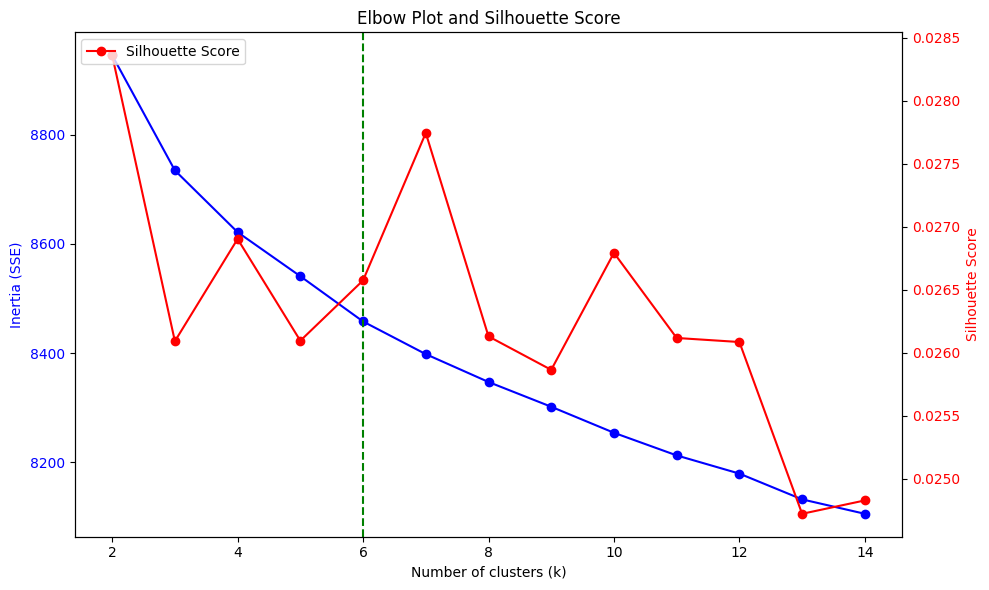

The optimal k on Elbow method is: 6


In [ ]:
k_values = range(2, 15)

# Calculate inertia (Elbow method) and silhouette scores
inertia = []
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

# KneeLocator to find the knee in elbow curve
knee_locator = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
optimal_k = knee_locator.knee

fig, ax1 = plt.subplots(figsize=(10, 6))
# Elbow plot - Inertia to Left y-axis
ax1.plot(k_values, inertia, 'bo-', label='Inertia (Elbow)', color='b')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (SSE)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Silhouette Score to Right y-axis
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'ro-', label='Silhouette Score', color='r')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax1.axvline(x=optimal_k, color='g', linestyle='--', label=f'Optimal k (Elbow) = {optimal_k}')

# plot
plt.title('Elbow Plot and Silhouette Score')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


print(f"The optimal k on Elbow method is: {optimal_k}")


In [ ]:
# KMeans with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(embeddings)
k_labels = kmeans.labels_
embeddings_array = np.array(embeddings)

 Plot

Using t-SNE we visually check how well articles are separated into clusters in a 2D space. We reduced the high-dimensional embeddings to 2D using t-SNE and plotted reviews.

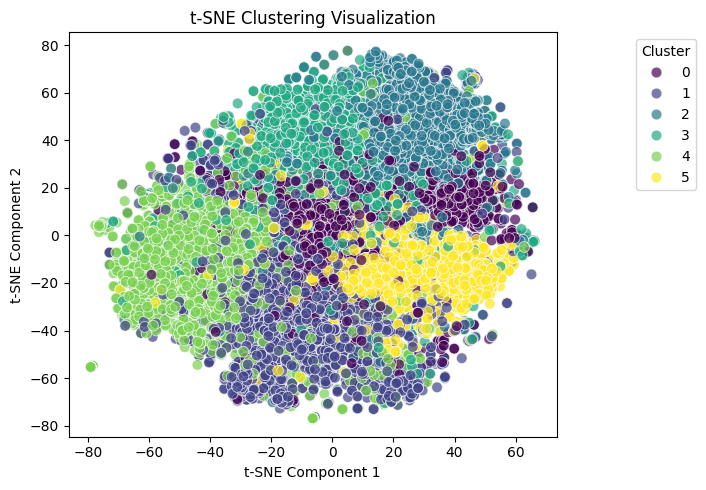

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=k_labels, palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Clustering Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.show()

 Word cloud


Word clouds display the most frequent words in each cluster helps to identify dominant themes or topics in the articles. We used custom stopwords to filtering out irrelevant and common terms so we coluld focus on meaningful words.

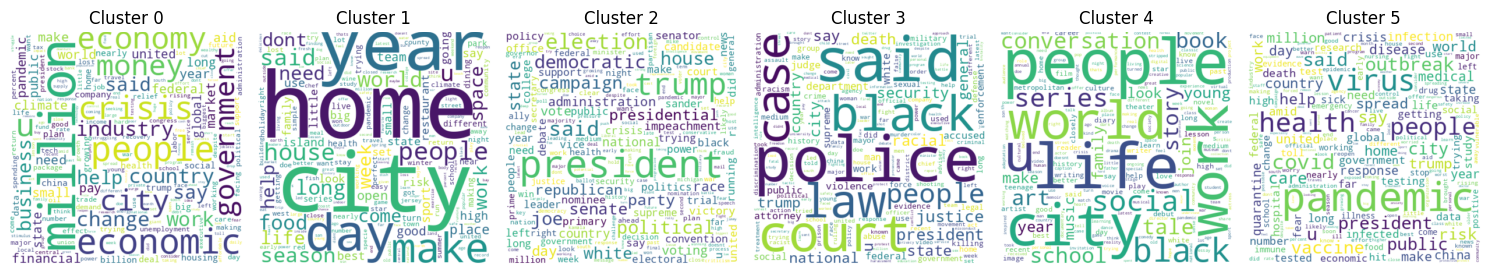

In [ ]:
# Define custom stopwords
custom_stopwords = {'york','time','new','wa','m','like','just','way'}#'like','film', 'movie','just','story','make'}

# Clustered articles DataFrame
clustered_articles = pd.DataFrame({'articles': articles_cleaned, 'cluster': k_labels})

# Create word clouds for each cluster
num_clusters = optimal_k
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 6), sharex=True, sharey=True)

for cluster in range(num_clusters):
    cluster_articles = clustered_articles[clustered_articles['cluster'] == cluster]['articles']
    words = " ".join(cluster_articles).split()
    word_freq = Counter(words)
    filtered_word_freq = {word: freq for word, freq in word_freq.items() if word not in custom_stopwords}
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(filtered_word_freq)

    # Plot
    ax = axes[cluster]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster}")

plt.tight_layout()
plt.show()


 **Hierarchical clustering**

Hierarchical clustering creates a tree-like structure (dendrogram) that shows how closely articales are related to each other. This helps in visualizing and understanding relationships between clusters and sub-clusters.

 Find best k

Defined possible k values from 3 to 15. Calculated the Pseudo-Inertia (Ward linkage distances) and Silhouette Scores. Used KneeLocator to determine the optimal number of clusters and verified the optimal k value using the Silhouette Score.

<ipython-input-8-f8dea26c40d4>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(k_values, pseudo_inertia, 'b-o', label='Pseudo-Inertia ', color='blue')
<ipython-input-8-f8dea26c40d4>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(k_values, silhouette_scores, 'r-o', label='Silhouette Score', color='red')


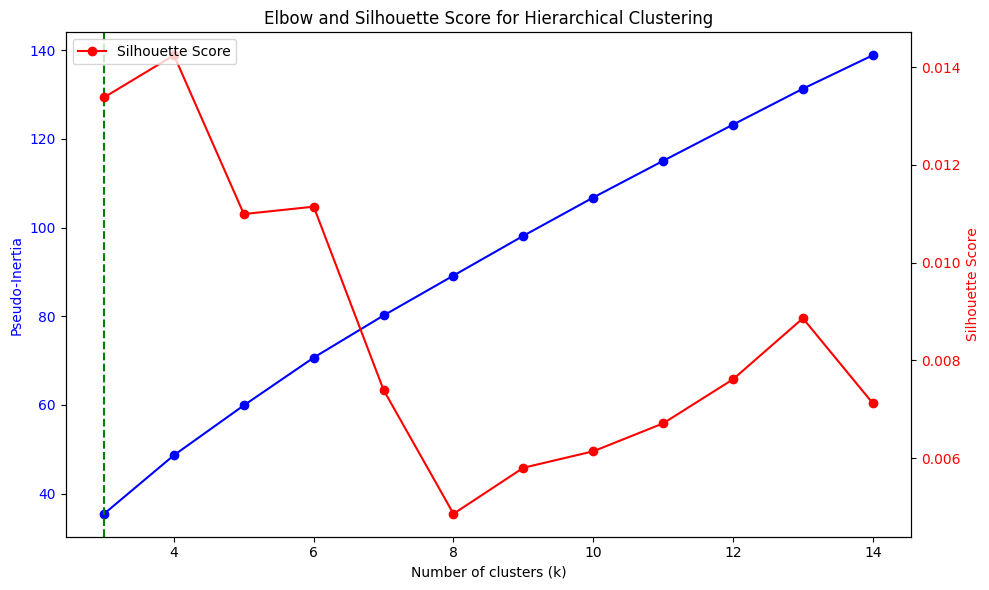

In [ ]:
k_values = range(3, 15)
pseudo_inertia = []
silhouette_scores = []

# Calculate scores for each k
for k in k_values:
    hier_model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hier_model.fit_predict(embeddings)
    silhouette_scores.append(silhouette_score(embeddings, labels))
    linkage_matrix = linkage(embeddings, method='ward')
    pseudo_inertia.append(np.sum(linkage_matrix[-(k-1):, 2]))

# KneeLocator
knee_locator = KneeLocator(k_values, pseudo_inertia, curve='convex', direction='decreasing')
optimal_k_elbow = knee_locator.knee

# Plot pseudo-inertia (Elbow method) and silhouette scores
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_values, pseudo_inertia, 'b-o', label='Pseudo-Inertia ', color='blue')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Pseudo-Inertia', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'r-o', label='Silhouette Score', color='red')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

if optimal_k_elbow is not None:
    ax1.axvline(x=optimal_k_elbow, color='green', linestyle='--', label=f'Optimal k (Elbow) = {optimal_k_elbow}')

# Plot
plt.title('Elbow and Silhouette Score for Hierarchical Clustering')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


In [ ]:
# Manually choosing the best k from above plot
optimal_k_elbow = 3
hier_model_final = AgglomerativeClustering(n_clusters=optimal_k_elbow, linkage='ward')
h_labels = hier_model_final.fit_predict(embeddings)

 Plot
 Visualizes the results of hierarchical clustering using t-SNE, a dimensionality reduction technique. Each data point (movie review) is plotted, and colors represent the clusters assigned by hierarchical clustering.

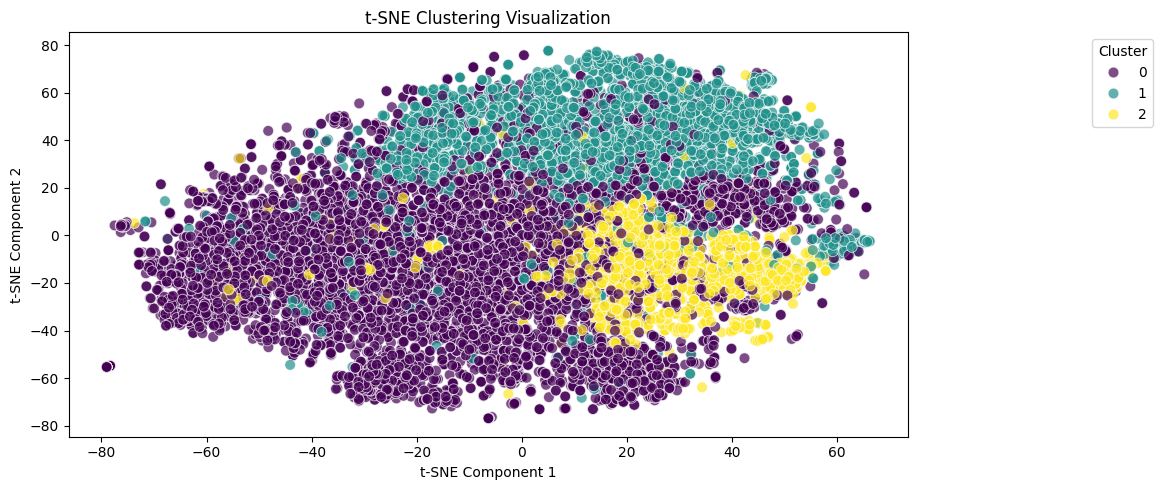

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
embeddings_array = np.array(embeddings)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Plot t-SNE
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=h_labels, palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Clustering Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

 Word cloud
We used the same method as in K-Means to create word clouds for hierarchical clustering. These word clouds highlight the dominant words in each cluster, helping us evaluate how well the clusters are formed.

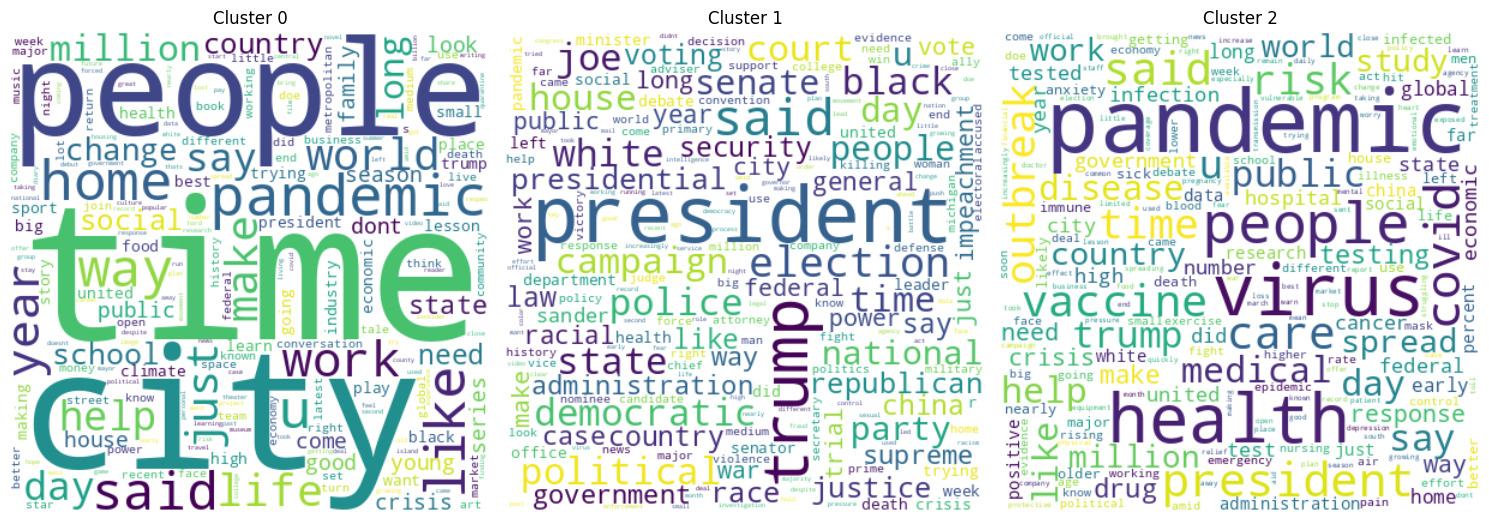

In [ ]:
# Remove custom stopwords
custom_stopwords = {'new','york','wa','m'}

# Word cloud for each cluster
clustered_articles = pd.DataFrame({'articles': articles_cleaned, 'cluster': h_labels})
num_clusters = optimal_k_elbow
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 6), sharex=True, sharey=True)

for cluster in range(num_clusters):
    cluster_articles = clustered_articles[clustered_articles['cluster'] == cluster]['articles']
    words = " ".join(cluster_articles).split()
    word_freq = Counter(words)
    filtered_word_freq = {word: freq for word, freq in word_freq.items() if word not in custom_stopwords}
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(filtered_word_freq)

    # Plot
    ax = axes[cluster]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster}")

plt.tight_layout()
plt.show()

 **DBSCAN**

DBSCAN is a clustering algorithm that groups dense areas and flags outliers. It doesn’t need the number of clusters in advance (unlike KMeans).

 Find best epsilon

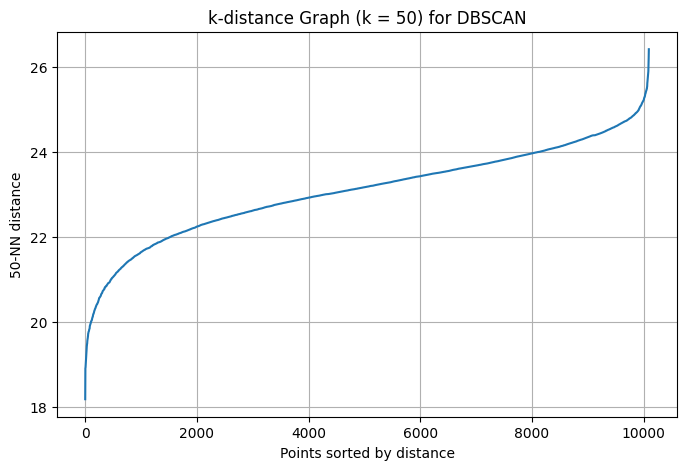

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

min_samples = 50
# Fit k-NN
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(embeddings_scaled)
distances, indices = neighbors_fit.kneighbors(embeddings_scaled)

# Sort the distances (take the kth NN distance)
k_distances = np.sort(distances[:, -1])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-NN distance')
plt.title(f'k-distance Graph (k = {min_samples}) for DBSCAN')
plt.grid(True)
plt.show()

In [29]:
final_eps = 10000
dbscan = DBSCAN(eps=final_eps, min_samples=50)
dbscan.fit(embeddings)
db_labels = dbscan.labels_

 Plot

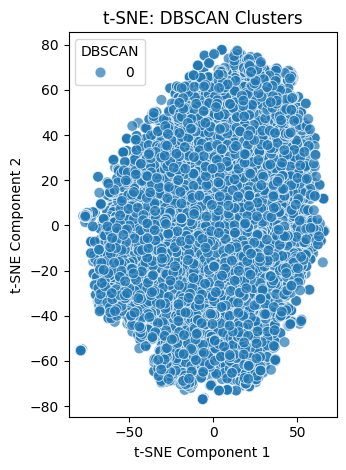

In [30]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_array = np.array(embeddings)
tsne_embeddings = tsne.fit_transform(embeddings_array)

plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=db_labels, palette='tab10', s=60, alpha=0.7)
plt.title("t-SNE: DBSCAN Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="DBSCAN", loc='best')

plt.tight_layout()
plt.show()

**Evaluation**

Silhouette Score- Measures how well each data point has been clustered. A higher value indicates better clustering. Higher values (closer to 1) indicate good clustering, while close to -1 indicate poor clustering.

Davies-Bouldin Index- Measures the compactness and separation of clusters. A lower score means better clustering.Lower values indicate better clustering performance.

Calinski-Harabasz Index- Measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate better clustering. A higher score suggests better clustering.

Cluster Size Comparison Plot- Visualize and compare the sizes of clusters formed by K-Means and Hierarchical Clustering.

In [ ]:
clustered_kmeans = pd.DataFrame({'articles': articles_cleaned, 'cluster': k_labels})
clustered_hierarchical = pd.DataFrame({'articles': articles_cleaned, 'cluster': h_labels})

# Top N words from each cluster using TF-IDF
def top_words(cluster_articles, n=10):
    vectorizer = TfidfVectorizer( max_features=1000)
    X = vectorizer.fit_transform(cluster_articles)
    terms = vectorizer.get_feature_names_out()
    scores = X.sum(axis=0).A1
    sorted_indices = scores.argsort()[::-1]
    top_word = [(terms[i], scores[i]) for i in sorted_indices[:n]]
    return top_word

n = 10
for cluster in range(optimal_k):
    kmeans_cluster_articles = clustered_kmeans[clustered_kmeans['cluster'] == cluster]['articles']
    print(f"K-Means Cluster {cluster} Top Words:", top_words(kmeans_cluster_articles, n))
for cluster in range(optimal_k_elbow):
    hier_cluster_articles = clustered_hierarchical[clustered_hierarchical['cluster'] == cluster]['articles']
    print(f"Hierarchical Cluster {cluster} Top Words:", top_words(hier_cluster_articles, n))


K-Means Cluster 0 Top Words: [('new', 46.04463189595008), ('million', 25.665364755347213), ('people', 24.392567399433375), ('economic', 24.207347648715892), ('crisis', 21.800786119354782), ('economy', 21.105009328637625), ('city', 18.65350910688238), ('money', 18.56756100148973), ('country', 18.53874223879446), ('government', 18.363240808834547)]
K-Means Cluster 1 Top Words: [('new', 77.39006347858619), ('wa', 50.992539503713076), ('home', 39.27255825812332), ('time', 34.804876702767935), ('city', 33.754060025048645), ('york', 32.52246704634264), ('just', 29.950101871810826), ('way', 28.679020526913522), ('year', 28.3074445663335), ('make', 25.31071214530706)]
K-Means Cluster 2 Top Words: [('president', 102.69623323652512), ('trump', 81.80433024447531), ('election', 44.68874382507938), ('wa', 43.45454972795561), ('said', 41.855496832476405), ('new', 38.368240033624176), ('political', 35.7546977569913), ('democratic', 34.9816579042633), ('house', 33.151127639106505), ('joe', 32.89524596

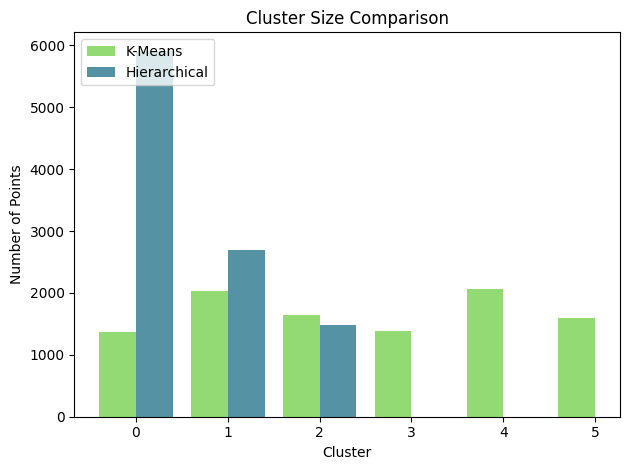

In [ ]:
# Cluster sizes comparison for K-Means and Hierarchical Clustering
k_cluster_sizes = pd.Series(k_labels).value_counts().sort_index()
h_cluster_sizes = pd.Series(h_labels).value_counts().sort_index()
all_clusters = sorted(set(k_cluster_sizes.index).union(h_cluster_sizes.index))
k_aligned = k_cluster_sizes.reindex(all_clusters)
h_aligned = h_cluster_sizes.reindex(all_clusters)

# Plot
colors = sns.color_palette("viridis", n_colors=4)
plt.bar(np.arange(len(all_clusters)) - 0.4 / 2, k_aligned.values, width=0.4, color=colors[3], label="K-Means", alpha=0.8)
plt.bar(np.arange(len(all_clusters)) + 0.4 / 2, h_aligned.values, width=0.4, color=colors[1], label="Hierarchical", alpha=0.8)
plt.title("Cluster Size Comparison")
plt.xlabel("Cluster")
plt.ylabel("Number of Points")
plt.xticks(np.arange(len(all_clusters)), all_clusters)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Silhouette Score
print(f"Silhouette Score for K-Means: {silhouette_score(embeddings, k_labels)}")
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_score(embeddings, h_labels)}")


Silhouette Score for K-Means: 0.026572545990347862
Silhouette Score for Hierarchical Clustering: 0.013382826000452042


In [ ]:
# Davies-Bouldin Index
print(f"Davies-Bouldin Index for K-Means: {davies_bouldin_score(embeddings, k_labels)}")
print(f"Davies-Bouldin Index for Hierarchical Clustering: {davies_bouldin_score(embeddings, h_labels)}")


Davies-Bouldin Index for K-Means: 5.375488445773118
Davies-Bouldin Index for Hierarchical Clustering: 5.916114633037265


In [ ]:
# Calinski-Harabasz Index
print(f"Calinski-Harabasz Index for K-Means: {calinski_harabasz_score(embeddings, k_labels)}")
print(f"Calinski-Harabasz Index for Hierarchical Clustering: {calinski_harabasz_score(embeddings, h_labels)}")


Calinski-Harabasz Index for K-Means: 176.87975401996312
Calinski-Harabasz Index for Hierarchical Clustering: 178.31756485506082


 **Topic modeling**

Topic modeling helps uncover hidden themes or topics in a collection of text data. In this project, it is used to analyze articles and identify recurring themes like science, art, politics.

 Data Cleaning
Used spaCy for text preprocessing and part-of-speech tagging.To ensure that only meaningful words are used for topic modeling.Retained only nouns, verbs, adjectives, and adverbs, as these are the most meaningful for topic modeling. Removed non-alphabetic characters, URLs, and stopwords.Filtered out reviews that were either too short (less than 10 words) or too long (more than 50 words) to ensure quality input.

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
# Lemmatizer and English words
lemmatizer = WordNetLemmatizer()
english_words_set = set(words.words())

def clean_text_with_spacy(text):
    if not isinstance(text, str) or pd.isnull(text):
        return None

    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Text with spaCy
    doc = nlp(text)

    # Lemmatize words and keep only nouns, verbs, adjectives
    important_words = []
    for token in doc:
        if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']:
            lemmatized_word = lemmatizer.lemmatize(token.text)
            if lemmatized_word in english_words_set:  # Keep valid English words
                important_words.append(lemmatized_word)

    cleaned_text = " ".join(important_words)

    # Sentences with more than 10 words or less than 50 words
    if len(important_words) < 10 or len(important_words) > 50:
        return None
    return cleaned_text

# Load the data
data_url = '/content/nyt-articles-2020.csv'
articles_raw_df = pd.read_csv(data_url)#.iloc[:16787]
articles = articles_raw_df['abstract']
articles_cleaned = articles.apply(clean_text_with_spacy).dropna()

print(articles_cleaned.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2    year long earth pass stream cosmic debris here...
3    never miss eclipse meteor shower rocket launch...
4    year full high low space just ended month come...
5    ability deploy militia attack embassy support ...
7    woman fell airport left side body answer malad...
Name: abstract, dtype: object


 **LDA**

LDA is a probabilistic topic modeling technique that assigns a distribution of topics to each document. It helps to discover coherent topics across the dataset.
LDA creats a dictionary and Bag-of-Words (BoW) corpus.

- Perplexity Scores: Measures how well the model predicts the data (lower is better).
- Coherence Scores: Measures the semantic similarity of words in each topic (higher is better).
Used these scores to determine the optimal number of topics.

4
5
6
7
8
9
10
11


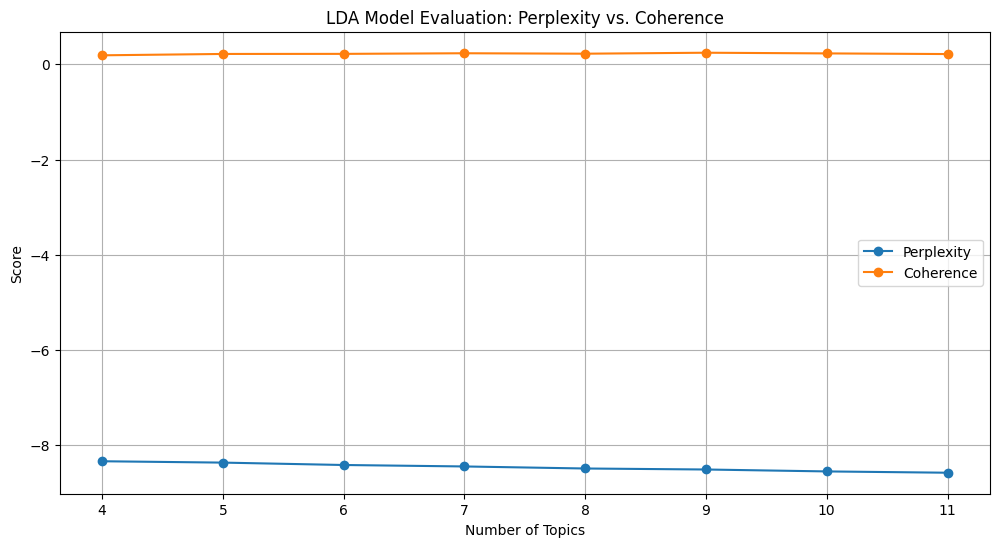

In [ ]:
# Tokenizing and removing stopwords
articles_cleaned_list = articles_cleaned.tolist()
tokenized_articles_list = [[word for word in word_tokenize(articles.lower()) if word not in stop_words] for articles in articles_cleaned_list]

# Create a dictionary & BOW corpus
dictionary = corpora.Dictionary(tokenized_articles_list)
corpus = [dictionary.doc2bow(articles) for articles in tokenized_articles_list]

# Perplexity and coherence scores
def evaluate_lda_model(corpus, dictionary, start=4, end=12):
    perplexity_scores = []
    coherence_scores = []

    for num_topics in range(start, end + 1):
        lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=20, iterations=300, workers=5)
        perplexity_scores.append(lda_model.log_perplexity(corpus))
        coherence_model = CoherenceModel(model=lda_model, texts=tokenized_articles_list, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherence_model.get_coherence())
        print(num_topics)
    return perplexity_scores, coherence_scores
perplexity_scores, coherence_scores = evaluate_lda_model(corpus, dictionary, start=4, end=11)

# Plot Perplexity and Coherence Scores
plt.figure(figsize=(12, 6))
plt.plot(range(4, 12), perplexity_scores, label='Perplexity', marker='o')
plt.plot(range(4, 12), coherence_scores, label='Coherence', marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Score')
plt.title('LDA Model Evaluation: Perplexity vs. Coherence')
plt.legend()
plt.grid(True)
plt.show()


Trained the LDA model with the optimal number of topics and visualized the results using PyLDAvis.

In [ ]:
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt_tab')

# Train the LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=6, id2word=dictionary, passes=20, iterations=500, workers=5)
topic_distributions = lda_model.get_document_topics(corpus)

# Create topic probabilities matrix
topic_vectors = []

for doc_topics in topic_distributions:
    topic_vector = np.zeros(lda_model.num_topics)
    for topic_id, prob in doc_topics:
        topic_vector[topic_id] = prob
    topic_vectors.append(topic_vector)
topic_vectors = np.array(topic_vectors)

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(topic_vectors)
labels = kmeans.labels_

# Visualize the topics with PyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, R=15)
pyLDAvis.display(vis)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


 **BERTopic**

BERTopic is an advanced topic modeling technique that combines topic modeling with embeddings from transformer models like Sentence-BERT. It provides more granular and meaningful topics compared to LDA.
We used the all-MiniLM-L6-v2 Sentence-Transformer model to generate embeddings for each review.
Applied BERTopic to cluster these embeddings and generate topics.

Visualized the topics using a bar chart showing the most relevant words for each topic.

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Sentence-Transformer Model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, language="english")
documents = articles_cleaned.tolist()
topics, probs = topic_model.fit_transform(documents)
topic_model.reduce_topics(documents, nr_topics=10)

# Print the reduced topics
print(topic_model.get_topic_info())
topic_model.visualize_topics()


/usr/local/lib/python3.11/dist-packages/hdbscan/plots.py:448: DeprecationWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.11/dist-packages/hdbscan/robust_single_linkage_.py:154: DeprecationWarning: invalid escape sequence '\{'
  """Perform robust single linkage clustering from a vector array
/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos


   Topic  Count                                  Name  \
0     -1   3782       -1_new_pandemic_president_trump   
1      0   1609              0_virus_new_vaccine_more   
2      1   1067        1_trump_president_police_black   
3      2    838               2_new_team_sport_player   
4      3    559           3_school_student_child_more   
5      4    171             4_wine_bottle_dish_recipe   
6      5    116         5_scientist_planet_bird_human   
7      6    114             6_risk_cancer_disease_men   
8      7     60  7_conversation_join_caption_stripped   
9      8     27          8_video_zoom_barking_meeting   

                                      Representation  \
0  [new, pandemic, president, trump, more, said, ...   
1  [virus, new, vaccine, more, pandemic, people, ...   
2  [trump, president, police, black, state, democ...   
3  [new, team, sport, player, season, game, theat...   
4  [school, student, child, more, parent, book, r...   
5  [wine, bottle, dish, recipe, make

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topics = topic_model.get_topics()
topics_lda = lda_model.show_topics(num_topics=10, formatted=False)

# Print the topics
for topic, words in topics.items():
    print(f"Topic {topic}: {', '.join([word[0] for word in words])}")
for topic_num, words in topics_lda:
    print(f"Topic {topic_num}: {', '.join([word[0] for word in words])}")

# Number of topics for BERTopic and LDA
print(f"Number of topics generated by BERTopic: {len(topic_model.get_topics())}")
print(f"Number of topics defined in LDA: {lda_model.num_topics}")


Topic -1: new, pandemic, president, trump, more, said, people, year, many, say
Topic 0: virus, new, vaccine, more, pandemic, people, mask, health, case, state
Topic 1: trump, president, police, black, state, democratic, woman, officer, said, impeachment
Topic 2: new, team, sport, player, season, game, theater, star, year, art
Topic 3: school, student, child, more, parent, book, reader, tale, diary, week
Topic 4: wine, bottle, dish, recipe, make, meal, delicious, sauce, simple, just
Topic 5: scientist, planet, bird, human, plant, animal, insect, specie, sea, earth
Topic 6: risk, cancer, disease, men, had, woman, people, exercise, depression, lower
Topic 7: conversation, join, caption, stripped, closely, invitation, ongoing, prompt, teenage, image
Topic 8: video, zoom, barking, meeting, silence, sound, quiet, modern, technological, telescope
Topic 0: new, trump, many, people, president, pandemic, school, year, time, say
Topic 1: state, said, president, trump, new, campaign, city, show, w

**Non-Negative Matrix Factorization (NMF)**

TF-IDF Embeddings
.

 Find best k

14


<ipython-input-23-14e93c36c448>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(k_values, silhouette_scores, 'r-o', label='Silhouette Score', color='red')


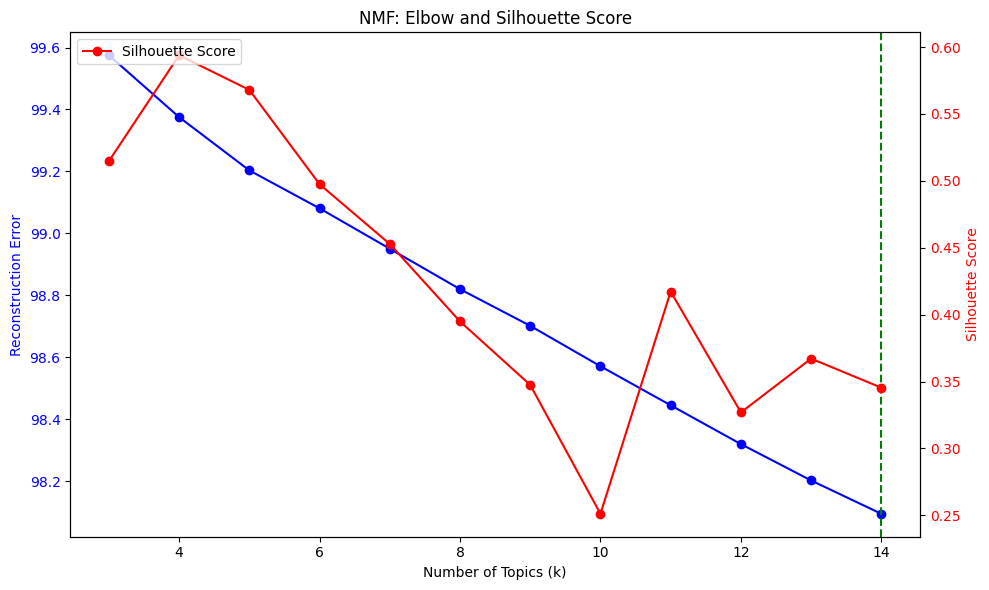

In [23]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(articles_cleaned)

k_values = range(3, 15)
reconstruction_errors = []
silhouette_scores = []

# Find numbers of topics
for k in k_values:
    nmf_model = NMF(n_components=k, random_state=42, init='nndsvd')
    W = nmf_model.fit_transform(tfidf)
    H = nmf_model.components_
    reconstruction_errors.append(nmf_model.reconstruction_err_)

    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(W)
    silhouette_scores.append(silhouette_score(W, labels))

# Find optimal k
knee_locator = KneeLocator(k_values, reconstruction_errors, curve='concave', direction='decreasing')
optimal_k_nmf = knee_locator.knee
print(optimal_k_nmf)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_values, reconstruction_errors, 'b-o', label='Reconstruction Error')
ax1.set_xlabel('Number of Topics (k)')
ax1.set_ylabel('Reconstruction Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'r-o', label='Silhouette Score', color='red')
ax2.set_ylabel('Silhouette Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

if optimal_k_nmf is not None:
    ax1.axvline(x=optimal_k_nmf, color='green', linestyle='--', label=f'Optimal k = {optimal_k_nmf}')

plt.title('NMF: Elbow and Silhouette Score')
fig.tight_layout()
plt.legend(loc='upper left')
plt.show()


In [24]:
print(optimal_k_nmf)
optimal_k_nmf=11

14


In [25]:
# Final NMF Model
nmf_model_final = NMF(n_components=optimal_k_nmf, random_state=42, init='nndsvd')
W_final = nmf_model_final.fit_transform(tfidf)

# KMeans for clustering
kmeans_final = KMeans(n_clusters=optimal_k_nmf, random_state=42)
nmf_labels = kmeans_final.fit_predict(W_final)

 Plot

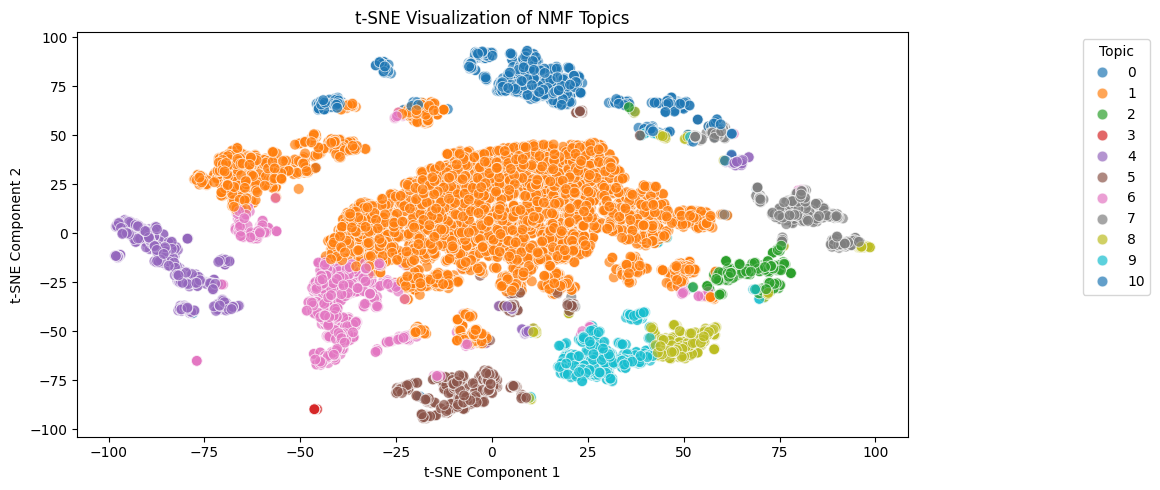

In [ ]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings_nmf = tsne.fit_transform(W_final)

plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_embeddings_nmf[:, 0], y=tsne_embeddings_nmf[:, 1], hue=nmf_labels, palette='tab10', s=60, alpha=0.7)
plt.title("t-SNE Visualization of NMF Topics")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Topic", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()

 Word cloud

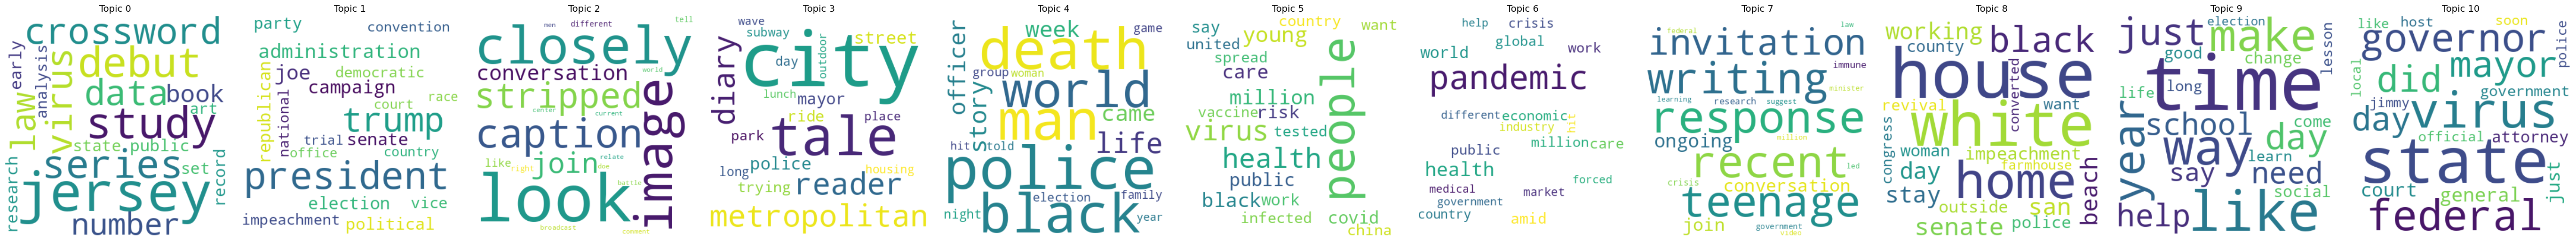

In [27]:
from wordcloud import WordCloud

# Custom stopwords
custom_stopwords = set(['new', 'times', 'york', 'wa', 'said'])

num_topics = optimal_k_nmf
fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 5), sharex=True, sharey=True)
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model_final.components_):
    # Get top 20 words
    top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-21:-1]}
    filtered_words = {word: weight for word, weight in top_words.items() if word not in custom_stopwords}
    wordcloud = WordCloud(width=400, height=400, background_color='white', stopwords=custom_stopwords).generate_from_frequencies(filtered_words)

    # Plot
    ax = axes[topic_idx]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {topic_idx}", fontsize=14)

plt.tight_layout()
plt.show()


 Semtiment analysis on Comments

In [31]:
from google.colab import drive
drive.mount('/content/drive')
comments_path = '/content/drive/MyDrive/nyt-comments-2020.csv'
comments_df = pd.read_csv(comments_path).iloc[:400000]
comments_df.head()


Mounted at /content/drive


<ipython-input-31-3b5028483284>:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv(comments_path).iloc[:400000]


commentID    status  commentSequence    userID userDisplayName  \
0  104387472  approved        104387472  60215558  magicisnotreal   
1  104387873  approved        104387873  65691034              JD   
2  104387976  approved        104387976  65110053           ebmem   
3  104390628  approved        104390628  60215558  magicisnotreal   
4  104391463  approved        104391463  65691034              JD   

  userLocation userTitle                                        commentBody  \
0        earth       NaN  Here is something I think is fraudulent that v...   
1         Elko       NaN  @magicisnotreal  I have used my VA loan option...   
2  Memphis, TN       NaN  @magi\n\nWhy would someone take out a VA loan ...   
3        earth       NaN  @JD\nOut here in the Alabama of the PNW they w...   
4         Elko       NaN  @magicisnotreal  just a guess but I doubt that...   

            createDate           updateDate  ... editorsSelection  \
0  2020-01-01 01:05:46  2020-01-01 08:13:39  ...            False   
1  2020-01-01 01:52:25  2020-01-01 20:55:19  ...            False   
2  2020-01-01 02:06:05  2020-01-01 20:55:35  ...            False   
3  2020-01-01 14:38:50  2020-01-01 20:56:46  ...            False   
4  2020-01-01 16:23:14  2020-01-01 16:25:57  ...            False   

      parentID  parentUserDisplayName  depth  commentType trusted  \
0          NaN                    NaN      1      comment       0   
1  104387472.0         magicisnotreal      2    userReply       0   
2  104387472.0         magicisnotreal      2    userReply       0   
3  104387873.0         magicisnotreal      2    userReply       0   
4  104390628.0         magicisnotreal      2    userReply       0   

   recommendedFlag     permID  isAnonymous  \
0                0  104387472        False   
1                0  104387873        False   
2                0  104387976        False   
3                0  104390628        False   
4                0  104391463        False   

                                           articleID  
0  nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...  
1  nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...  
2  nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...  
3  nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...  
4  nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...  

[5 rows x 23 columns]

In [32]:
!pip install vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
english_words_set = set(words.words())

def clean_text_with_spacy(text):
    if not isinstance(text, str) or pd.isnull(text):
        return None
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text
comments_df['cleaned_comment'] = comments_df['commentBody'].astype(str).apply(clean_text_with_spacy)

# Vader model
comments_df['sentiment'] = comments_df['cleaned_comment'].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Convert to labels
comments_df['sentiment_label'] = pd.cut(comments_df['sentiment'], bins=[-1, -0.05, 0.05, 1], labels=['negative', 'neutral', 'positive'])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
comments_df.head()
article_sentiment = comments_df.groupby('articleID')['sentiment_label'].agg(lambda x: x.mode()[0]).reset_index()
article_sentiment.head()

articleID sentiment_label
0  nyt://article/00036db7-8494-5141-b0ac-414118ca...        negative
1  nyt://article/004716c5-8943-5bf4-8293-864ab083...        positive
2  nyt://article/00573cb4-92bb-53b7-ad9a-6d4d1e73...        positive
3  nyt://article/00bea7d5-c04a-509d-a82f-7537a16d...        positive
4  nyt://article/012aeb93-8149-522b-a18b-d6cfc620...        positive

In [34]:
article_sentiment.columns = ['uniqueID', 'article_sentiment']
articles_df = pd.read_csv('/content/nyt-articles-2020.csv')
articles_with_sentiment = articles_df.merge(article_sentiment, on='uniqueID', how='left')
section_sentiment = articles_with_sentiment.groupby('section')['article_sentiment'].value_counts(normalize=True).unstack().fillna(0)
print(section_sentiment)
# Drop sections where all sentiment values are zero
section_sentiment = section_sentiment[(section_sentiment != 0).any(axis=1)]


article_sentiment     negative   neutral  positive
section                                           
Admin                 0.000000  0.000000  0.000000
Arts                  0.131579  0.052632  0.815789
At Home               0.000000  0.000000  0.000000
Automobiles           0.000000  0.000000  1.000000
Books                 0.233333  0.033333  0.733333
Briefing              0.000000  0.000000  0.000000
Business Day          0.228571  0.000000  0.771429
Climate               0.300000  0.000000  0.700000
Crosswords & Games    0.000000  0.025641  0.974359
Education             0.000000  0.000000  0.000000
Fashion & Style       0.000000  0.000000  1.000000
Food                  0.081081  0.000000  0.918919
Health                0.333333  0.000000  0.666667
International Home    0.000000  0.000000  0.000000
Magazine              0.333333  0.000000  0.666667
Movies                0.050000  0.000000  0.950000
New York              0.371795  0.000000  0.628205
Obituaries            0.333333 

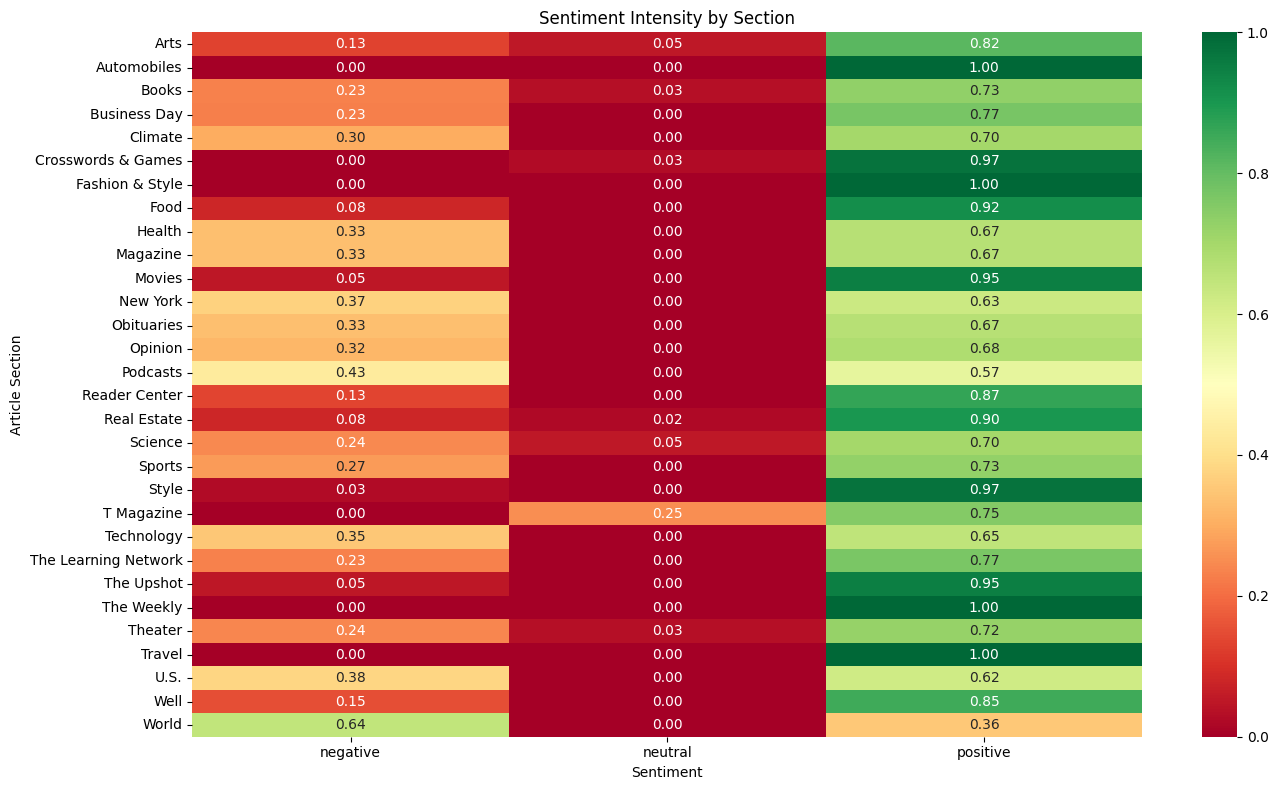

In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(section_sentiment, annot=True, cmap="RdYlGn", fmt=".2f")
plt.title("Sentiment Intensity by Section")
plt.xlabel("Sentiment")
plt.ylabel("Article Section")
plt.tight_layout()
plt.show()


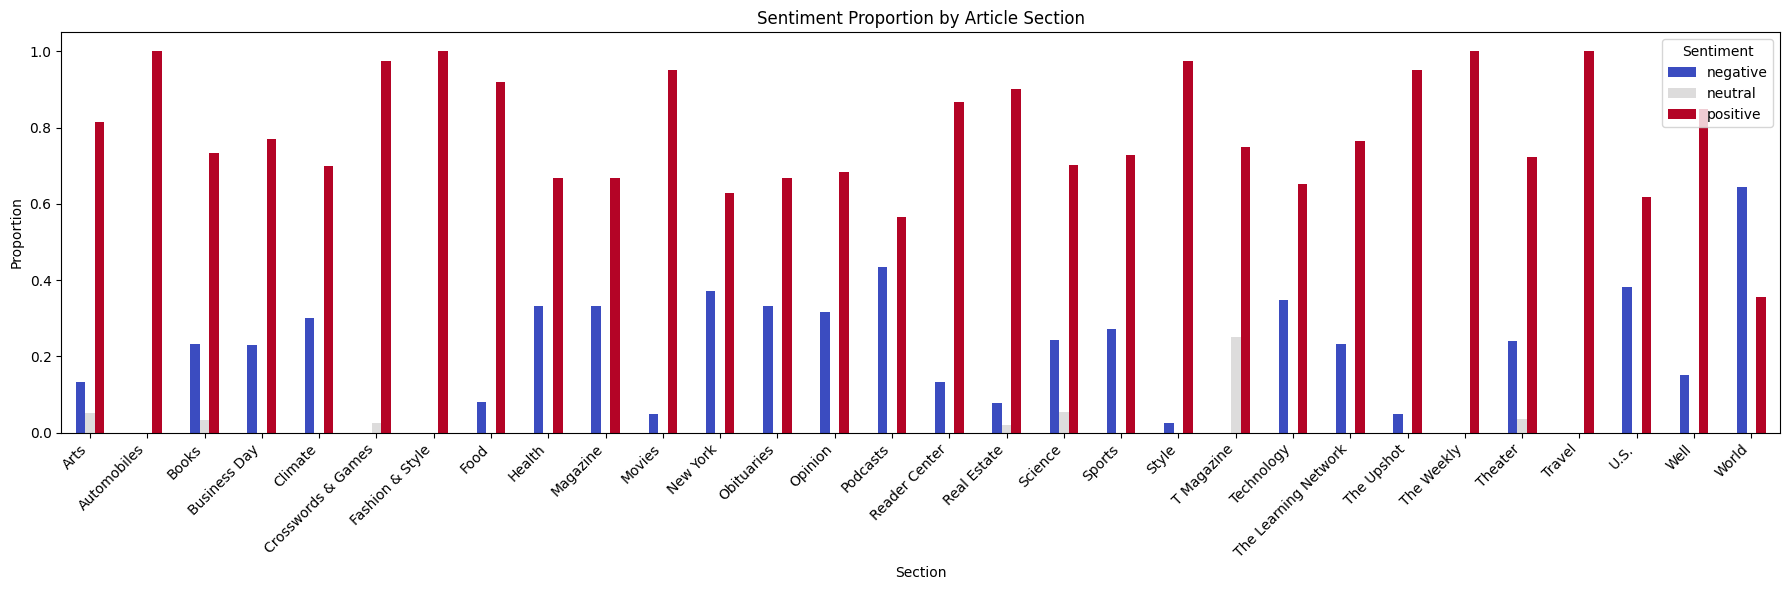

In [ ]:
section_sentiment.plot(kind='bar', figsize=(18, 6), colormap='coolwarm')
plt.title("Sentiment Proportion by Article Section")
plt.ylabel("Proportion")
plt.xlabel("Section")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


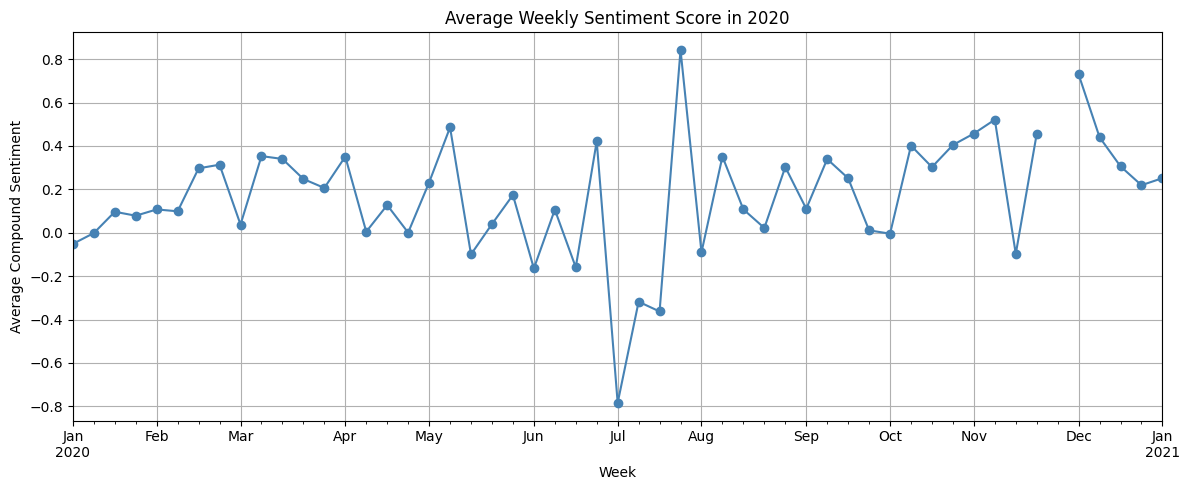

In [ ]:
# Convert to datetime
comments_df['createDate'] = pd.to_datetime(comments_df['createDate'])

# Filter for comments from the year 2020 only
comments_2020 = comments_df[comments_df['createDate'].dt.year == 2020]

# Group by week and calculate average sentiment
timeline_2020 = comments_2020.groupby(pd.Grouper(key='createDate', freq='W'))['sentiment'].mean()

# Plot
timeline_2020.plot(figsize=(12, 5), marker='o', color='steelblue')
plt.title("Average Weekly Sentiment Score in 2020")
plt.ylabel("Average Compound Sentiment")
plt.xlabel("Week")
plt.grid(True)
plt.tight_layout()
plt.show()
